<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/model_01_lsi_sections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sections as Input

In [1]:
pip install wandb

In [2]:
!wandb login

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [3]:
import wandb

In [4]:
!pip uninstall gensim -y

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2


In [5]:
!pip install gensim

  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)


In [6]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import similarities
import pickle
import os
import zipfile


In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
print(gensim.__version__)

4.1.2


In [9]:
!rm data.csv

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Configuration


In [11]:
use_wandb = True

In [12]:
generate_webapp_data = False

In [13]:
docu = 'sections'
chords_preprocessing = 'rootAndDegreesPlus'

In [14]:
ngrams_for_input = [2]

In [15]:
remove_repetitions = False

In [16]:
input_files = {
    'sections': {
        # M7 and 6 reduced to major triad, m7 reduced to m, dominant 7, m7b5, diminished, and all (b5) left as they are.
        'rootAndDegreesPlus': '1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c',
        'rootAndDegrees7': '',
        'rootAndDegreesSimplified': '1vyC9voFf2vpcKmS5kZBJ9Rafm7wuuzD8',
    },
}

In [17]:
contrafacts = [
               ("26-2 [jazz1350]", "Confirmation [jazz1350]"),
               ("52nd Street Theme [jazz1350]", "I Got Rhythm [jazz1350]"), # not a good match
               ("Ablution [jazz1350]", "All The Things You Are [jazz1350]"),
               ("Anthropology [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Bright Mississippi [jazz1350]", "Sweet Georgia Brown [jazz1350]"),
               ("C.T.A. [jazz1350]", "I Got Rhythm [jazz1350]"),
               #( "Celia [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Cottontail [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Countdown [jazz1350]", "Tune Up [jazz1350]"),
               ("Dewey Square [jazz1350]", "Oh, Lady Be Good [jazz1350]"),
               ("Dexterity [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Dig [jazz1350]", "Sweet Georgia Brown [jazz1350]"),
               ("Donna Lee [jazz1350]", "Indiana (Back Home Again In) [jazz1350]"),
               ("Don't Be That Way [jazz1350]", "I Got Rhythm [jazz1350]"),  # cannot be found; bridge in different key
               #("Eternal Triangle [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Evidence [jazz1350]", "Just You, Just Me [jazz1350]"),
               ("Flintstones [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Four On Six [jazz1350]", "Summertime [jazz1350]"),
               ("Freight Train [jazz1350]", "Blues For Alice [jazz1350]"),
               ("Good Bait [jazz1350]", "I Got Rhythm [jazz1350]"),  # A sections
               ("Hackensack [jazz1350]", "Oh, Lady Be Good [jazz1350]"),
               ("Half Nelson [jazz1350]", "Lady Bird [jazz1350]"),
               ("Hot House [jazz1350]", "What Is This Thing Called Love [jazz1350]"),
               ("Impressions [jazz1350]", "So What [jazz1350]"),
               ("In A Mellow Tone (In A Mellotone) [jazz1350]", "Rose Room [jazz1350]"),
               ("In Walked Bud [jazz1350]", "Blue Skies [jazz1350]"),
               ("Ko Ko [jazz1350]", "Cherokee [jazz1350]"),
               ("Lennie's Pennies [jazz1350]", "Pennies From Heaven [jazz1350]"),   ## Lennie's Pennies is in minor and therefore transposed to Amin... not possible to recognize like that
               #( "Let's Call This [jazz1350]", "Honeysuckle Rose [jazz1350]"),
               ("Little Rootie Tootie [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Little Willie Leaps [jazz1350]", "All God's Chillun Got Rhythm [jazz1350]"),
               ("Lullaby Of Birdland [jazz1350]", "Love Me Or Leave Me [jazz1350]"),
               #("Moose The Mooche [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("My Little Suede Shoes [jazz1350]", "Jeepers Creepers [jazz1350]"),
               #("Oleo [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Ornithology [jazz1350]", "How High The Moon [jazz1350]"),
               #("Passport [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Quasimodo (Theme) [jazz1350]", "Embraceable You [jazz1350]"),
               #("Rhythm-a-ning [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Room 608 [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Salt Peanuts [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Satellite [jazz1350]", "How High The Moon [jazz1350]"),
               ("Scrapple From The Apple [jazz1350]", "Honeysuckle Rose [jazz1350]"), # A section
               ("Scrapple From The Apple [jazz1350]", "I Got Rhythm [jazz1350]"), # B section
               #("Segment [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Seven Come Eleven [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Shaw 'Nuff [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Theme, The [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Tour De Force [jazz1350]", "Jeepers Creepers [jazz1350]"),
               ("Wow [jazz1350]", "You Can Depend On Me [jazz1350]"),
               ("Yardbird Suite [jazz1350]", "Rosetta [jazz1350]"),

               # following tunes are not from wikipedia),
               ("Sweet Sue, Just You [jazz1350]", "Honeysuckle Rose [jazz1350]"),  # A section
               #("All Of Me [jazz1350]", "Pennies From Heaven [jazz1350]"), # bars 25-28 of All of Me are same as bars 17-20 of Pennies From Heaven, but different key!
               ("Sweet Sue, Just You [jazz1350]", "Bye Bye Blackbird [jazz1350]"), # Bridge same
               ("These Foolish Things [jazz1350]", "Blue Moon [jazz1350]"), # first 8 bars same
               ("These Foolish Things [jazz1350]", "More Than You Know [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Isn't It A Pity [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Soultrane [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Why Do I Love You [jazz1350]"),
               ("Misty [jazz1350]", "Portrait Of Jennie [jazz1350]"),
               ("Misty [jazz1350]", "September In The Rain [jazz1350]"),
               ("Misty [jazz1350]", "I May Be Wrong [jazz1350]"),  

               # identical tunes
               ("Five Foot Two [trad]", "Please Don't Talk About Me When I'm Gone [trad]"),
               ("What Is This Thing Called Love [jazz1350]", "Subconscious Lee [jazz1350]"),
               ("Sweet Georgia Brown [jazz1350]", "Dig [jazz1350]"),


               # almost identical tunes
               ("What Is This Thing Called Love [jazz1350]", "Hot House [jazz1350]"),
               ("Jeannie's Song [jazz1350]", "Shiny Stockings [jazz1350]"),
               ("Alone Together [jazz1350]", "Segment [jazz1350]"),
               ("Baubles, Bangles and Beads [jazz1350]", "Bossa Antigua [jazz1350]"),
               ("There Will Never Be Another You [jazz1350]", "A Weaver Of Dreams [jazz1350]"),
               ("Moten Swing [jazz1350]", "Once In A While (Ballad) [trad]"), # same bridge, similar A
               ("All I Do Is Dream Of You [trad]", "L-O-V-E [jazz1350]"),


               # same A section
               ("Nancy (With The Laughing Face) [jazz1350]", "Body And Soul [jazz1350]"),
               ("Exactly Like You [jazz1350]", "True (You Don't Love Me ) [trad]"),
               ("Exactly Like You [jazz1350]", "Jersey Bounce [jazz1350]"),
               ("Take The A Train [jazz1350]", "Girl From Ipanema, The [jazz1350]"),
               ("My Heart Stood Still [jazz1350]", "All Too Soon [jazz1350]"),
               ("Undecided [jazz1350]", "Broadway [jazz1350]"),
               ("Let's Fall In Love [jazz1350]", "Heart And Soul [jazz1350]"),
               ("Come Back To Me [jazz1350]", "I Wish I Knew [jazz1350]"),
               ("Wait Till You See Her [jazz1350]", "A Certain Smile [jazz1350]"),
               ("Killer Joe [jazz1350]", "Straight Life [jazz1350]"),
               ("Softly, As In A Morning Sunrise [jazz1350]", "Segment [jazz1350]"),
               ("Bei Mir Bist Du Schon (Root Hog Or Die) [trad]", "Egyptian Fantasy [trad]"),
               ("Bei Mir Bist Du Schon (Root Hog Or Die) [trad]", "Puttin' On The Ritz [jazz1350]"),
               ("Coquette [trad]", "Pretend You're Happy When You're Blue [trad]"),
               ("Softly, As In A Morning Sunrise [jazz1350]", "Strode Rode [jazz1350]"),
               ("Glory Of Love, The [jazz1350]", "I've Got My Fingers Crossed [trad]"),
               ("Charleston, The [jazz1350]", "As Long As I Live [trad]"),
               ("Fine And Dandy [jazz1350]", "I Can't Give You Anything But Love [jazz1350]"),
               ("I'll Close My Eyes [jazz1350]", "Bluesette [jazz1350]"),
               ("I'll Close My Eyes [jazz1350]", "There Will Never Be Another You [jazz1350]"),



               # same bridge
               ("If I Had You [jazz1350]", "Too Young To Go Steady [jazz1350]"),
               ("Undecided [jazz1350]", "Satin Doll [jazz1350]"),
               ("Billy Boy [jazz1350]", "Elora [jazz1350]"),
               ("Dearly Beloved [jazz1350]", "We See [jazz1350]"),
               ("Alone Together [jazz1350]", "A Night In Tunisia [jazz1350]"),
               ("A Night In Tunisia [jazz1350]", "Segment [jazz1350]"),
               ("Oh! Lady Be Good [trad]", "Sentimental Journey [jazz1350]"),
               ("You Can Depend On Me [jazz1350]", "Move [jazz1350]"),
               ("I Want To Be Happy [jazz1350]", "A Beautiful Friendship [jazz1350]"),
               ("Flying Home [jazz1350]", "Down For Double [jazz1350]"),
               ("Cheek To Cheek [jazz1350]", "Violets For Your Furs [jazz1350]"),
               ("Let's Fall In Love [jazz1350]", "At Last [jazz1350]"),
               ("Don't Be That Way [jazz1350]", "Long Ago And Far Away [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "I'm Confessin' That I Love You [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "Eclypso [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "You Stepped Out Of A Dream [jazz1350]"),
               ("Satin Doll [jazz1350]", "Undecided [jazz1350]"),
               

               

               # similar A section
               ("I Like The Likes Of You [jazz1350]", "Mountain Greenery [jazz1350]"),
               ("My Secret Love [jazz1350]", "Samba De Orfeu [jazz1350]"),
               ("Let's Call The Whole Thing Off [jazz1350]", "Fine And Dandy [jazz1350]"),


               # similar B section
               ("Folks Who Live On The Hill, The [jazz1350]", "My One And Only Love [jazz1350]"),
               ("As Long As I Live [trad]", "I'm Glad There Is You [jazz1350]"),
               ("I May Be Wrong [jazz1350]", "Teach Me Tonight [jazz1350]"),
               ("Am I Blue [jazz1350]", "Come Back To Me [jazz1350]"),
               ("My One And Only Love [jazz1350]", "Am I Blue [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "September In The Rain [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "Mountain Greenery [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "There's No You [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Embraceable You [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Rosetta [jazz1350]"),

               # same C section
               ("Bill Bailey [jazz1350]", "Bourbon Street Parade [jazz1350]"),

               # Stella C is like Woody B
               ("Woody'n You [jazz1350]", "Stella By Starlight [jazz1350]"),

               # similar vocabulary, different progressions
               ("Tangerine [jazz1350]", "Tea For Two [jazz1350]"),
               ("I Can't Give You Anything But Love [jazz1350]", "You Can Depend On Me [jazz1350]"),
               ("This Year's Kisses [jazz1350]", "My Monday Date [trad]"),
               ("A Blossom Fell [jazz1350]", "Among My Souvenirs [jazz1350]"),

]

In [18]:
test_tunes = []
for ref, sim in contrafacts:
  if ref not in test_tunes:
    test_tunes.append(ref)
  if sim not in test_tunes:
    test_tunes.append(sim)

test_tunes.sort()
len(test_tunes)

168

In [19]:
test_contrafacts = [
               ("These Foolish Things [jazz1350]", "Why Do I Love You [jazz1350]"),
]

In [20]:
len(contrafacts)

115

# Initialization

## Download the Data

In [21]:
input_data = input_files['sections'][chords_preprocessing]

input_path = f"https://docs.google.com/uc?export=download&id={input_data}"
data_file_name = 'data.csv'


In [22]:
input_path

'https://docs.google.com/uc?export=download&id=1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c'

In [23]:
!wget --no-check-certificate "$input_path" -O "$data_file_name"

--2021-12-27 15:51:37--  https://docs.google.com/uc?export=download&id=1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c
Resolving docs.google.com (docs.google.com)... 108.177.125.113, 108.177.125.101, 108.177.125.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f2ck4be6dk28j674vrqbvdv9sbu4ttf1/1640620275000/14329102864480165501/*/1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c?e=download [following]
--2021-12-27 15:51:38--  https://doc-0g-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f2ck4be6dk28j674vrqbvdv9sbu4ttf1/1640620275000/14329102864480165501/*/1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c?e=download
Resolving doc-0g-4c-docs.googleusercontent.com (doc-0g-4c-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0g-4c-docs.googleusercontent.com (doc-0g-

### Read Chords Input Data

In [24]:
df = pd.read_csv(data_file_name, sep='\t', index_col="id")
df = df.reset_index()
df.head(5)

,id,file_name,title,title_playlist,tune_mode,tune_id,section_name,section_id,chords
0,0,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,1,C Eb7 G# B7 E G7 Gm C7 F G#7 C# E7 Am D7 Dm G7
1,1,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,2,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
2,2,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,B,3,Gm C7 Bm E7 A C7 F Bbm Eb7 G# Dm G7
3,3,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,4,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
4,4,dataset/jazz1350/500 Miles High.xml,500 Miles High,500 Miles High [jazz1350],minor,1,A,1,Am Am Cm Cm Eb Eb Em7b5 A7 Dm Dm Bm7b5 Bm7b5 B...


### Meta Data

In [25]:
titles = df.loc[:, ['id', 'tune_id', 'section_id', 'section_name', 'title', 'title_playlist', 'tune_mode']]
titles[:5]

,id,tune_id,section_id,section_name,title,title_playlist,tune_mode
0,0,0,1,A,26-2,26-2 [jazz1350],major
1,1,0,2,A,26-2,26-2 [jazz1350],major
2,2,0,3,B,26-2,26-2 [jazz1350],major
3,3,0,4,A,26-2,26-2 [jazz1350],major
4,4,1,1,A,500 Miles High,500 Miles High [jazz1350],minor


In [26]:
titles_dict = titles.to_dict()

sectionid_to_title = titles_dict['title_playlist']
sectionid_to_titleid = titles_dict['tune_id']


In [27]:
tunes = df.loc[:, ['tune_id', 'title_playlist']].drop_duplicates()
tunes = tunes.set_index('tune_id').to_dict()
titleid_to_title = tunes['title_playlist']

In [28]:
len(titleid_to_title)

1686

In [29]:
title_to_titleid = {v: k for k, v in titleid_to_title.items()}


In [30]:
titles_rows = titles.to_dict(orient='records')
sectionid_to_section = []
for i, row in enumerate(titles_rows):
  name = f"{row['title']}, section{row['section_id']} ({row['section_name']})"
  sectionid_to_section.append(name)
  

In [31]:
sectionid_to_sectionlabel = []
for i, row in enumerate(titles_rows):
  sectionid_to_sectionlabel.append(row['section_name'])
  

In [32]:
title_to_sectionid = {}

for row in titles.iterrows():
  title = row[1]['title_playlist']
  if title not in title_to_sectionid:
    title_to_sectionid[title] = [row[1]['id']]
  else:
    title_to_sectionid[title].append(row[1]['id'])

### Create Directories on Colab

In [33]:
!rm -R output
!mkdir output

## Initialization for wandb variables

In [34]:
recommender_results_cols = ['reference', 'id', 'method', 'similar', 'score_div_max', 'score']
recommender_results = pd.DataFrame(columns=recommender_results_cols)

In [35]:
lsi_config = {
    'num_topics': 100, #22, # 100 gives a better value for the contrafacts test
}

In [36]:
if use_wandb:
  wandb.init(
        # Set entity to specify your username or team name
        # ex: entity="carey",
        # Set the project where this run will be logged
        project="lsi_model", 
        
        # Track hyperparameters and run metadata
        config={
            "input_data": input_path,
            "ngrams_input": ngrams_for_input,
            "comparison": docu,
            "lsi": lsi_config,
            "remove_repeated_chords": remove_repetitions,
            "comment": ""
        }
    )

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [37]:
if use_wandb:
  artifact = wandb.Artifact('input_data', type='dataset')
  artifact.add_file('data.csv')
  wandb.log_artifact(artifact)

## Helpers functions

In [38]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [39]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

# Data Preparation

In [40]:
def remove_chord_repetitions(chords):
  previous = ''
  chords_norep = []
  for c in chords:
    if c != previous:
      chords_norep.append(c)
      previous = c
  return chords_norep
  

In [41]:
lines = df.loc[:, 'chords'].tolist()
data = [line.split(' ') for line in lines]

In [42]:
test_tunes[:5]

['26-2 [jazz1350]',
 '52nd Street Theme [jazz1350]',
 'A Beautiful Friendship [jazz1350]',
 'A Blossom Fell [jazz1350]',
 'A Certain Smile [jazz1350]']

In [43]:
test_tune_sectionid = []
for title in test_tunes:
  test_tune_sectionid.extend(title_to_sectionid[title])

test_tune_sectionid[:10]

[0, 1, 2, 3, 7, 8, 9, 10, 19, 20]

In [44]:
len(data)

5536

In [45]:
processed_corpus = []
test_corpus = []

#for line in data:
for id, line in enumerate(data):  
  tune_n = []
  if remove_repetitions:
    line = remove_chord_repetitions(line)
  for n in ngrams_for_input:
    tune_n.extend(ngrams(line, n=n))
  processed_corpus.append(tune_n)
  if id not in test_tune_sectionid:
    test_corpus.append(tune_n)

for line in processed_corpus[:10]:
  print(line)

['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'G#7', 'C#', 'E7', 'Am', 'D7', 'Dm', 'G7', 'C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-G#7', 'G#7-C#', 'C#-E7', 'E7-Am', 'Am-D7', 'D7-Dm', 'Dm-G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C', 'C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-C']
['Gm', 'C7', 'Bm', 'E7', 'A', 'C7', 'F', 'Bbm', 'Eb7', 'G#', 'Dm', 'G7', 'Gm-C7', 'C7-Bm', 'Bm-E7', 'E7-A', 'A-C7', 'C7-F', 'F-Bbm', 'Bbm-Eb7', 'Eb7-G#', 'G#-Dm', 'Dm-G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C', 'C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-C']
['Am', 'Am', 'Cm', 'Cm', 'Eb', 'Eb', 'Em7b5', 'A7', 'Dm', 'Dm', 'Bm7b5', 'Bm7b5', 'Bbm', 'Bbm', 'Fm', 'Fm', 'E7', 'E7', 'Fm', 'Fm', 'C#', 'C#', 'Fm', 'Fm', 'C#', 'C#', 'Am-Am', '

In [46]:
len(processed_corpus)

5536

#### Corpus Overview

In [47]:
tokens = [item for l in processed_corpus for item in l]
total_tokens = len(tokens)
vocab_size = len(set(tokens))
vocab_prop = 100*vocab_size/total_tokens

print(f"Total Number of tokens: {total_tokens}")
print(f"Size of vocabulary: {vocab_size}")
print(f"Proportion of vocabulary in corpus: {vocab_prop:.02f}%")

Total Number of tokens: 147906
Size of vocabulary: 2112
Proportion of vocabulary in corpus: 1.43%


In [48]:
df_chords = raw_chords_to_df(processed_corpus)
df_chords.head(10)

,chord,count
0,C,12890
5,G7,9688
14,Dm,7498
12,Am,5443
29,Dm-G7,4888
31,G7-C,4374
45,A7,4128
13,D7,3578
8,F,3419
7,C7,3111


In [49]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

2021-12-27 15:51:50,927 : INFO : NumExpr defaulting to 2 threads.


Plot Distribution accoring to Zipf's Law

source: https://stats.stackexchange.com/questions/331219/characterizing-fitting-word-count-data-into-zipf-power-law-lognormal

In [50]:
from collections import Counter

counter_of_words = df_chords.set_index('chord').to_dict(orient='dict')
counter_of_words = Counter(counter_of_words['count'])

word_counts = sorted(counter_of_words.values(), reverse=True)
frequency_rank = np.array(list(range(1, len(word_counts) + 1)))

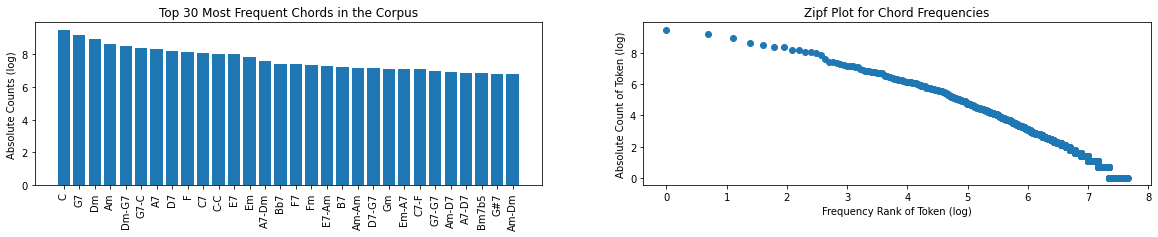

In [51]:
plt.figure(figsize=(20, 3))

plt.subplot(1, 2, 1)

n = 30
df_top = df_chords_top.head(n)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Chords in the Corpus')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

plt.subplot(1, 2, 2)

plt.scatter(np.log(frequency_rank), np.log(word_counts))
plt.xlabel('Frequency Rank of Token (log)')
plt.ylabel('Absolute Count of Token (log)')
plt.title('Zipf Plot for Chord Frequencies')

plt.savefig('plot.png')

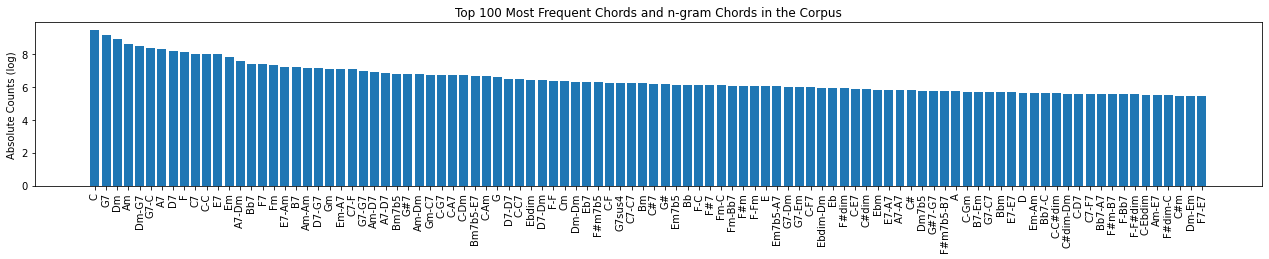

In [52]:
plt.figure(figsize=(22, 3))

n = 100

df_top = df_chords_top.head(n)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Chords and n-gram Chords in the Corpus')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

In [53]:
if use_wandb:
  wandb.log(
      {"corpus": {
              "total_tokens": total_tokens,
              "vocab_size": vocab_size,
              "vocab_proportion_in_corpus": vocab_prop,
              "zipf_plot": wandb.Image('plot.png'),
              "data_encoding": "tfidf",
              }
      }
  )

In [54]:
!rm -R index
!mkdir index

## Test Functions


In [55]:
def get_sim_scores(tunes, index, model, topn=50):

    df_sim = pd.DataFrame(columns=['reference_title',
                                   'reference_titleid',
                                   'similar_title',
                                   'similar_titleid',
                                   'ref_section', 
                                   'ref_section_label',
                                   'ref_sectionid',
                                   'similar_section',
                                   'similar_section_label',
                                   'similar_sectionid',
                                   'score', 
                                  ])

    for tune in tqdm(tunes):
      for s1 in title_to_sectionid[tune]:
      
          query = processed_corpus[s1]
          query_bow = dictionary.doc2bow(query)

          # perform a similarity query against the corpus
          similarities = index[model[query_bow]]
          sims = sorted(enumerate(similarities), key=lambda item: -item[1])
          
          n = 0
          for s2, s2_score in sims:
            
            # store the top N best results
            if n > topn:
                break
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
                # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")
                n += 1
                df_sim.loc[len(df_sim)] = [tune,
                                           title_to_titleid[tune],
                                           sectionid_to_title[s2],
                                           sectionid_to_titleid[s2],
                                           sectionid_to_section[s1],
                                           sectionid_to_sectionlabel[s1],
                                           s1,
                                           sectionid_to_section[s2], 
                                           sectionid_to_sectionlabel[s2],
                                           s2,
                                           s2_score, 
                                           ]
    return df_sim

## Test Contrafacts

With the model, query the top N highest matches for each section. For a tune, if at least one section receives the recommendation  for the expected title, increase the match counter.

In [56]:
def test_contrafacts(tunes, index, model, N=15):
  matches = 0
  number_of_sections = 0
  results = {}

  for tune, similar_tune in tunes:

    # loop over all sections of the tune
    section_matches = 0
    rank = 0
    score = 0

    for s1 in title_to_sectionid[tune]:
      query = processed_corpus[s1]
      query_bow = tfidf[dictionary.doc2bow(query)]

      # perform a similarity query against the corpus
      similarities = index[model[query_bow]]
      sims = sorted(enumerate(similarities), key=lambda item: -item[1])
      #print(f"s1: {s1}")
      #print(f"similar_tune: {similar_tune}, {title_to_sectionid[similar_tune]}")
      #print(sims)
      #print(len(sims))
      
      # check if the section matches the expected title; consider only the first N recommendations
      i = 0
      for sectionid, value in sims:
        if i >= N:
          break
        if sectionid_to_title[sectionid] == similar_tune:
          section_matches += 1
          print(f"Found {tune} - {similar_tune} {sectionid_to_sectionlabel[sectionid]} with value {value}")
          if value > score:
            rank = i
            score = value
          break
        i += 1

    # for each title, increase matches if at least one of the section matched the expected title
    if section_matches > 0:
      matches += 1  
      results[f'{tune}, {similar_tune}'] = {'found': 1,
                                            'score': score,
                                            'rank': rank}
    else:
      score = 0
      for sectionid in title_to_sectionid[similar_tune]:
        sim_value = similarities[sectionid]
        score = sim_value if sim_value > score else score

      results[f'{tune}, {similar_tune}'] = {'found': 0,
                                            'score': score,
                                            'rank': rank}
  
  return matches, results


# LSA (Latent Semantic Analysis), aka LSI (Latent Semantic Index) 

In [57]:
from collections import defaultdict

Use the Test Corpus to train the LSI Model.

In [89]:
dictionary = corpora.Dictionary(processed_corpus)
print(len(dictionary))
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=1.0)
print(len(dictionary))
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

2021-12-27 15:57:39,473 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-12-27 15:57:39,697 : INFO : built Dictionary(2112 unique tokens: ['Am', 'Am-D7', 'B7', 'B7-E', 'C']...) from 5536 documents (total 147906 corpus positions)
2021-12-27 15:57:39,699 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(2112 unique tokens: ['Am', 'Am-D7', 'B7', 'B7-E', 'C']...) from 5536 documents (total 147906 corpus positions)", 'datetime': '2021-12-27T15:57:39.699753', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-12-27 15:57:39,709 : INFO : discarding 1508 tokens: [('C#-E7', 5), ('F-Eb7', 6), ('A-C7', 2), ('F-Bbm', 8), ('Bbm-Fm', 5), ('Bm7b5-Bbm', 2), ('Bm7b5-Bm7b5', 9), ('C#-Fm', 6), ('Cm-Eb', 1), ('E7-Fm', 4)]...
2021-12-27 15:57:39,711 : INFO : keeping 604 tokens which were in no less than 10 and no more than 5536 (=100.0%) documents
2021-12-

2112
604


In [90]:
for doc in bow_corpus[:5]:
   print([[dictionary[id], freq] for id, freq in doc])

[['Am', 1], ['Am-D7', 1], ['B7', 1], ['B7-E', 1], ['C', 1], ['C#', 1], ['C-Eb7', 1], ['C7', 1], ['C7-F', 1], ['D7', 1], ['D7-Dm', 1], ['Dm', 1], ['Dm-G7', 1], ['E', 1], ['E-G7', 1], ['E7', 1], ['E7-Am', 1], ['Eb7', 1], ['Eb7-G#', 1], ['F', 1], ['F-G#7', 1], ['G#', 1], ['G#-B7', 1], ['G#7', 1], ['G#7-C#', 1], ['G7', 2], ['G7-Gm', 1], ['Gm', 1], ['Gm-C7', 1]]
[['B7', 2], ['B7-E', 2], ['C', 2], ['C-Eb7', 1], ['C7', 1], ['C7-F', 1], ['E', 2], ['E-G7', 2], ['Eb7', 2], ['Eb7-G#', 2], ['F', 1], ['G#', 2], ['G#-B7', 2], ['G7', 2], ['G7-Gm', 1], ['Gm', 1], ['Gm-C7', 1], ['G7-C', 1]]
[['C7', 2], ['C7-F', 1], ['Dm', 1], ['Dm-G7', 1], ['E7', 1], ['Eb7', 1], ['Eb7-G#', 1], ['F', 1], ['G#', 1], ['G7', 1], ['Gm', 1], ['Gm-C7', 1], ['A', 1], ['Bbm', 1], ['Bbm-Eb7', 1], ['Bm', 1], ['Bm-E7', 1], ['C7-Bm', 1], ['E7-A', 1], ['G#-Dm', 1]]
[['B7', 2], ['B7-E', 2], ['C', 2], ['C-Eb7', 1], ['C7', 1], ['C7-F', 1], ['E', 2], ['E-G7', 2], ['Eb7', 2], ['Eb7-G#', 2], ['F', 1], ['G#', 2], ['G#-B7', 2], ['G7', 2], [

In [91]:
tfidf = TfidfModel(bow_corpus)

2021-12-27 15:57:42,898 : INFO : collecting document frequencies
2021-12-27 15:57:42,901 : INFO : PROGRESS: processing document #0
2021-12-27 15:57:42,934 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 5536 documents and 604 features (92710 matrix non-zeros)', 'datetime': '2021-12-27T15:57:42.934867', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'initialize'}


In [92]:
tfidf_corpus = tfidf[bow_corpus]

for doc in tfidf_corpus[:5]:
   print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])

[['Am', 0.06], ['Am-D7', 0.12], ['B7', 0.11], ['B7-E', 0.24], ['C', 0.02], ['C#', 0.2], ['C-Eb7', 0.3], ['C7', 0.07], ['C7-F', 0.1], ['D7', 0.06], ['D7-Dm', 0.14], ['Dm', 0.03], ['Dm-G7', 0.04], ['E', 0.2], ['E-G7', 0.33], ['E7', 0.07], ['E7-Am', 0.11], ['Eb7', 0.16], ['Eb7-G#', 0.23], ['F', 0.06], ['F-G#7', 0.37], ['G#', 0.18], ['G#-B7', 0.38], ['G#7', 0.13], ['G#7-C#', 0.28], ['G7', 0.03], ['G7-Gm', 0.22], ['Gm', 0.11], ['Gm-C7', 0.13]]
[['B7', 0.15], ['B7-E', 0.33], ['C', 0.03], ['C-Eb7', 0.21], ['C7', 0.05], ['C7-F', 0.07], ['E', 0.27], ['E-G7', 0.46], ['Eb7', 0.22], ['Eb7-G#', 0.32], ['F', 0.04], ['G#', 0.25], ['G#-B7', 0.53], ['G7', 0.02], ['G7-Gm', 0.15], ['Gm', 0.08], ['Gm-C7', 0.09], ['G7-C', 0.03]]
[['C7', 0.16], ['C7-F', 0.12], ['Dm', 0.03], ['Dm-G7', 0.05], ['E7', 0.08], ['Eb7', 0.19], ['Eb7-G#', 0.27], ['F', 0.07], ['G#', 0.21], ['G7', 0.02], ['Gm', 0.13], ['Gm-C7', 0.15], ['A', 0.25], ['Bbm', 0.24], ['Bbm-Eb7', 0.28], ['Bm', 0.21], ['Bm-E7', 0.25], ['C7-Bm', 0.46], ['E7-A

In [93]:
#dictionary.token2id

In [94]:
test_dictionary = corpora.Dictionary(test_corpus)
test_bow_corpus = [dictionary.doc2bow(text) for text in test_corpus]

2021-12-27 15:57:53,900 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-12-27 15:57:54,108 : INFO : built Dictionary(2090 unique tokens: ['A7', 'A7-Dm', 'Am', 'Am-Am', 'Am-Cm']...) from 4915 documents (total 133317 corpus positions)
2021-12-27 15:57:54,110 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(2090 unique tokens: ['A7', 'A7-Dm', 'Am', 'Am-Am', 'Am-Cm']...) from 4915 documents (total 133317 corpus positions)", 'datetime': '2021-12-27T15:57:54.110249', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [95]:
corpus = tfidf_corpus
model_dictionary = dictionary

In [96]:
num_topics = lsi_config['num_topics']

lsi = LsiModel(corpus, 
               id2word=model_dictionary, 
               num_topics=num_topics)

2021-12-27 15:57:57,478 : INFO : using serial LSI version on this node
2021-12-27 15:57:57,481 : INFO : updating model with new documents
2021-12-27 15:57:58,043 : INFO : preparing a new chunk of documents
2021-12-27 15:57:58,089 : INFO : using 100 extra samples and 2 power iterations
2021-12-27 15:57:58,092 : INFO : 1st phase: constructing (604, 200) action matrix
2021-12-27 15:57:58,175 : INFO : orthonormalizing (604, 200) action matrix
2021-12-27 15:57:58,347 : INFO : 2nd phase: running dense svd on (200, 5536) matrix
2021-12-27 15:57:58,623 : INFO : computing the final decomposition
2021-12-27 15:57:58,633 : INFO : keeping 100 factors (discarding 15.783% of energy spectrum)
2021-12-27 15:57:58,649 : INFO : processed documents up to #5536
2021-12-27 15:57:58,652 : INFO : topic #0(21.538): 0.276*"C-C" + 0.250*"C" + 0.219*"Dm-G7" + 0.197*"Am" + 0.194*"Dm" + 0.193*"D7" + 0.188*"F" + 0.187*"G7-C" + 0.179*"A7" + 0.166*"G7-G7"
2021-12-27 15:57:58,655 : INFO : topic #1(14.205): 0.397*"Am" 

Use the Full Corpus to calculate the similarity matrix.

In [97]:
index_lsi = similarities.Similarity('/content/index/index_lsi', lsi[corpus], num_features=len(model_dictionary))

2021-12-27 15:58:07,190 : INFO : starting similarity index under /content/index/index_lsi


In [98]:
#index_lsi = similarities.SparseMatrixSimilarity(lsi[bow_corpus], num_features = len(dictionary))
#index_lsi = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it


In [99]:
lsi.save('/content/index/lsi.model')
index_lsi.save('/content/index/lsi_matrixsim.index')


2021-12-27 15:58:11,280 : INFO : Projection lifecycle event {'fname_or_handle': '/content/index/lsi.model.projection', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-27T15:58:11.280041', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-12-27 15:58:11,284 : INFO : saved /content/index/lsi.model.projection
2021-12-27 15:58:11,286 : INFO : LsiModel lifecycle event {'fname_or_handle': '/content/index/lsi.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': ['projection', 'dispatcher'], 'datetime': '2021-12-27T15:58:11.286217', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-12-27 15:58:11,287 : INFO : not storing attribute projection
2021-12-27 15:58:11,289 : INFO : not storing attribute dispatch

In [100]:
!ls -la /content/index

total 4856
drwxr-xr-x 2 root root    4096 Dec 27 15:52 .
drwxr-xr-x 1 root root    4096 Dec 27 15:51 ..
-rw-r--r-- 1 root root 4451041 Dec 27 15:58 index_lsi.0
-rw-r--r-- 1 root root     749 Dec 27 15:58 lsi_matrixsim.index
-rw-r--r-- 1 root root   17460 Dec 27 15:58 lsi.model
-rw-r--r-- 1 root root  484691 Dec 27 15:58 lsi.model.projection


## Tests

### Tests for Contrafacts

In [101]:
len(contrafacts)

115

In [102]:
topN = 30
matches, results = test_contrafacts(contrafacts, index_lsi, lsi, topN)

print(f"Found matches: {matches} out of {len(results)}: {100*matches/len(results):.3f}%")
print() 
for rr, val in results.items():
  if val == 0:
    print(f"{val}: {rr}")


Found 26-2 [jazz1350] - Confirmation [jazz1350] B with value 0.7507338523864746
Found Ablution [jazz1350] - All The Things You Are [jazz1350] A with value 0.9031974673271179
Found Ablution [jazz1350] - All The Things You Are [jazz1350] B with value 0.8414434790611267
Found Ablution [jazz1350] - All The Things You Are [jazz1350] C with value 0.9394088983535767
Found Ablution [jazz1350] - All The Things You Are [jazz1350] D with value 0.5065211653709412
Found Anthropology [jazz1350] - I Got Rhythm [jazz1350] B with value 1.0000001192092896
Found Bright Mississippi [jazz1350] - Sweet Georgia Brown [jazz1350] A with value 0.8373429179191589
Found Bright Mississippi [jazz1350] - Sweet Georgia Brown [jazz1350] A with value 0.817128598690033
Found C.T.A. [jazz1350] - I Got Rhythm [jazz1350] B with value 1.0000001192092896
Found Cottontail [jazz1350] - I Got Rhythm [jazz1350] B with value 1.0000001192092896
Found Countdown [jazz1350] - Tune Up [jazz1350] A with value 0.7414323687553406
Found D

In [103]:
results

{'26-2 [jazz1350], Confirmation [jazz1350]': {'found': 1,
  'rank': 1,
  'score': 0.75073385},
 '52nd Street Theme [jazz1350], I Got Rhythm [jazz1350]': {'found': 0,
  'rank': 0,
  'score': 0.5467995},
 'A Blossom Fell [jazz1350], Among My Souvenirs [jazz1350]': {'found': 1,
  'rank': 1,
  'score': 0.90165186},
 'A Night In Tunisia [jazz1350], Segment [jazz1350]': {'found': 1,
  'rank': 2,
  'score': 0.9999999},
 'Ablution [jazz1350], All The Things You Are [jazz1350]': {'found': 1,
  'rank': 1,
  'score': 0.9394089},
 'All I Do Is Dream Of You [trad], L-O-V-E [jazz1350]': {'found': 1,
  'rank': 2,
  'score': 0.95181346},
 'Alone Together [jazz1350], A Night In Tunisia [jazz1350]': {'found': 1,
  'rank': 0,
  'score': 0.9999999},
 'Alone Together [jazz1350], Segment [jazz1350]': {'found': 1,
  'rank': 2,
  'score': 0.9999999},
 'Am I Blue [jazz1350], Come Back To Me [jazz1350]': {'found': 1,
  'rank': 1,
  'score': 0.97316116},
 'Anthropology [jazz1350], I Got Rhythm [jazz1350]': {'fou

In [104]:
df_sim = pd.DataFrame.from_dict(results, orient='index')
df_sim = df_sim.reset_index()
df_sim.sort_values('index')
print(df_sim)

                                                 index  found     score  rank
0             26-2 [jazz1350], Confirmation [jazz1350]      1  0.750734     1
1    52nd Street Theme [jazz1350], I Got Rhythm [ja...      0  0.546799     0
2    Ablution [jazz1350], All The Things You Are [j...      1  0.939409     1
3     Anthropology [jazz1350], I Got Rhythm [jazz1350]      1  1.000000     5
4    Bright Mississippi [jazz1350], Sweet Georgia B...      1  0.837343     8
5           C.T.A. [jazz1350], I Got Rhythm [jazz1350]      1  1.000000     5
6       Cottontail [jazz1350], I Got Rhythm [jazz1350]      1  1.000000     5
7             Countdown [jazz1350], Tune Up [jazz1350]      1  0.741432     6
8    Dewey Square [jazz1350], Oh, Lady Be Good [jaz...      0  0.114581     0
9        Dexterity [jazz1350], I Got Rhythm [jazz1350]      1  1.000000     5
10      Dig [jazz1350], Sweet Georgia Brown [jazz1350]      1  1.000000     1
11   Donna Lee [jazz1350], Indiana (Back Home Again...      1  0

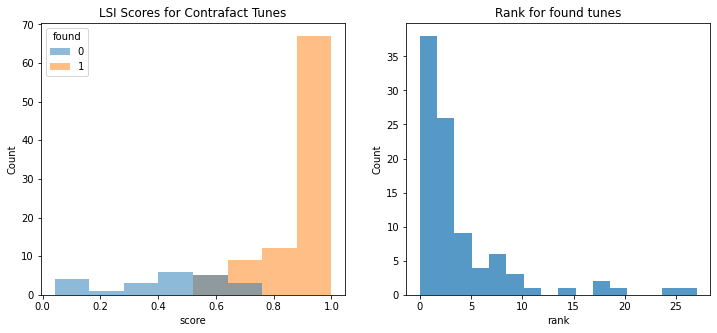

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(ax=ax[0],
             data=df_sim, 
             x='score', 
             hue='found', 
             stat='count', 
             edgecolor=None)
ax[0].set_title('LSI Scores for Contrafact Tunes')

sns.histplot(ax=ax[1],
             data=df_sim[df_sim.found==1], 
             x='rank', 
             stat='count', 
             edgecolor=None)
ax[1].set_title('Rank for found tunes')

plt.savefig('plot.png')

In [75]:
fig = px.histogram(df_sim, x="score", color='found', title='LSI Scores for found tunes')
fig.show()


In [76]:
fig = px.histogram(df_sim[df_sim.found==1], x="rank", title='Rank on which tune is found')
fig.show()

In [77]:
model_name = 'lsi'
if use_wandb:
  wandb.log(
      {model_name: {
                'contrafacts': {
                    'topN': topN,
                    'success': matches/len(contrafacts),
                    'results': wandb.Table(data=df_sim),
                    'score_histogram': wandb.Image('plot.png'),
                    }
                   },
       })

### Get Recommender Data for WebApp

In [78]:
test_data = [
  "Sweet Sue, Just You [jazz1350]",
  "On The Sunny Side Of The Street [jazz1350]",
  "These Foolish Things [jazz1350]", 
  "Blue Moon [jazz1350]",
  "I Got Rhythm [jazz1350]",
  "Old Fashioned Love [trad]",
  "Exactly Like You [jazz1350]",
  "Honeysuckle Rose [jazz1350]",
  "Misty [jazz1350]",
  "Wow [jazz1350]",
  "Take The A Train [jazz1350]"
]

test_data = sorted(test_data)

In [79]:
%%time
if False:
  #_tunes = list(tunes['title_playlist'].values())
  _tunes = test_data

  method = 'lsi'

  # save the mapping between titleid and title to disk
  pd.DataFrame.from_dict(tunes).to_csv(f'output/index_{method}.csv', index_label='titleid')
  with zipfile.ZipFile(f'output/index_{method}.zip', 'w') as zf:
    zf.write(f'output/index_{method}.csv')

  df_sim = get_sim_scores(_tunes, index_lsi, lsi, topn=30)

  # save to file
  (df_sim
   .loc[:,[#'reference_title',
           'reference_titleid',
           #'similar_title',
           'similar_titleid',
           'ref_section_label',
           'similar_section_label',
           'score'
           ]]
   .groupby(['reference_titleid', 
          #'reference_title', 
          'similar_titleid',
          #'similar_title', 
          'ref_section_label', 
          'similar_section_label'])
   .max('score')
   .reset_index()
   .to_csv(f'output/recommender_{method}.csv', encoding='utf8', index=False)
  )
  
  with zipfile.ZipFile(f'output/recommender_{method}.zip', 'w') as zf:
    zf.write(f'output/recommender_{method}.csv')

  # save to wandb
  if use_wandb:
    model_artifact = wandb.Artifact(
        f"recommender_{method}", 
        type="csv",
        description=f"Recommendations for each Tune using {method} Model (csv file)",
        metadata="")

    model_artifact.add_file(f'output/recommender_{method}.zip')
    model_artifact.add_file(f'output/index_{method}.zip')
    wandb.log_artifact(model_artifact)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


## Store Model to W&B

In [80]:
if use_wandb:
  model_artifact = wandb.Artifact(
      "model_lsi", 
      type="model",
      description="LSI model",
      metadata="")

  model_artifact.add_file("/content/index/lsi.model")
  model_artifact.add_file("/content/index/lsi_matrixsim.index")
  model_artifact.add_file("/content/index/lsi.model.projection")
  wandb.log_artifact(model_artifact)

## Determine Number of Topics for LSI Model

This sample comes from Datacamp: 

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


What is the best way to determine k (number of topics) in topic modeling? Identify the optimum number of topics in the given corpus text is a challenging task. We can use the following options for determining the optimum number of topics:

* One way to determine the optimum number of topics is to consider each topic as a cluster and find out the effectiveness of a cluster using the Silhouette coefficient.
* Topic coherence measure is a realistic measure for identifying the number of topics.

Topic Coherence measure is a widely used metric to evaluate topic models. It uses the latent variable models. Each generated topic has a list of words. In topic coherence measure, you will find average/median of pairwise word similarity scores of the words in a topic. The high value of topic coherence score model will be considered as a good topic model. 

In [81]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [82]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [83]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)

    runs = 5
    for i in range(runs):
      model_list, coherence_values = compute_coherence_values(dictionary, 
                                                              doc_term_matrix,
                                                              doc_clean,
                                                              stop, start, step)
      # Show graph
      x = range(start, stop, step)
      plt.plot(x, coherence_values, color='blue')

    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.show()

In [84]:
# evaluate a good number of topics for the LSI Model. This takes some time.

if False:

  start, stop, step = 2, 50, 2
  plot_graph(data, start, stop, step)

For unigrams, the best number of topics that is most consistently for the 5 runs seems to be around 22.

For unigrams plus bigrams, the coherence score drops down until 100 and then continuously rises until 500 and continues to rise. Same for bigrams-only.

# W&B Logging and Finish

In [85]:
if use_wandb:
  wandb.finish()